<div style="float:left">
            <h1 style="width:450px">Data Creation Notebook</h1>
    <h2 style="width:450px">Assemble Training Data for <i>Intro to Programming</i></h2>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

This notebook creates the composite data set used in the Geocomputation module. You are welcome to add additional data sets for the purposes of the final assessment in the module if you so wish.

In [1]:
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import geopandas as gpd

## AirBnB Listings

We take picks the large data set since we want to give the students maximum flexibility to find attributes of interest in the data set.

In [3]:
# Where is the data stored?
url = 'http://data.insideairbnb.com/united-kingdom/england/london/2020-08-24/data/listings.csv.gz'

# Download and check the shape
df = pd.read_csv(url, low_memory=False) # The 'low memory' option means pandas doesn't guess data types
print("Data frame shape: " + str(df.shape)) # What is the shape of the data?

Data frame shape: (74186, 74)


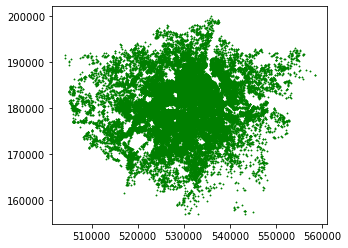

In [4]:
# Convert lat/log to points
from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]

# Drop these columns and reproject into OSBG
df.drop(['longitude', 'latitude'], axis=1, inplace=True)
airbnb = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)
airbnb = airbnb.to_crs('EPSG:27700')
airbnb.plot(marker='*', color='green', markersize=1)
del(df)

## LSOA Data

Since we don't really cover spatial joins in this class I've appended the LSOA values from 2011 here so that students can add on other information of interest and/or aggregate the listings in useful ways.

<AxesSubplot:>

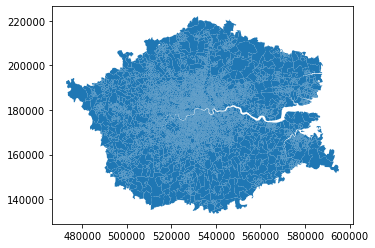

In [5]:
lsoas = gpd.read_file('https://github.com/jreades/i2p/raw/master/data/src/LSOAs.gpkg', driver='GPKG')
lsoas.plot()

## Join the Data

Join the LSOA and Inside Airbnb data sets.

['id' 'listing_url' 'scrape_id' 'last_scraped' 'name' 'description'
 'neighborhood_overview' 'picture_url' 'host_id' 'host_url' 'host_name'
 'host_since' 'host_location' 'host_about' 'host_response_time'
 'host_response_rate' 'host_acceptance_rate' 'host_is_superhost'
 'host_thumbnail_url' 'host_picture_url' 'host_neighbourhood'
 'host_listings_count' 'host_total_listings_count' 'host_verifications'
 'host_has_profile_pic' 'host_identity_verified' 'neighbourhood'
 'neighbourhood_cleansed' 'neighbourhood_group_cleansed' 'property_type'
 'room_type' 'accommodates' 'bathrooms' 'bathrooms_text' 'bedrooms' 'beds'
 'amenities' 'price' 'minimum_nights' 'maximum_nights'
 'minimum_minimum_nights' 'maximum_minimum_nights'
 'minimum_maximum_nights' 'maximum_maximum_nights'
 'minimum_nights_avg_ntm' 'maximum_nights_avg_ntm' 'calendar_updated'
 'has_availability' 'availability_30' 'availability_60' 'availability_90'
 'availability_365' 'calendar_last_scraped' 'number_of_reviews'
 'number_of_reviews

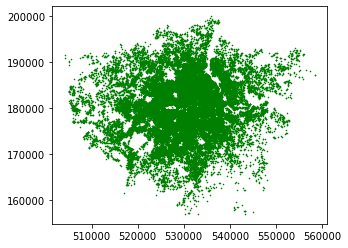

In [6]:
# Spatial join in way that preserves Inside Airbnb coordinates
gdf = gpd.sjoin(airbnb, lsoas, how="left", op='within', rsuffix='r')
gdf.drop(columns=['index_r','objectid','lsoa11nmw','st_lengths'], inplace=True)
gdf.plot(marker='*', color='green', markersize=0.5)
print(gdf.columns.values)

## Wrapping Up

Save the final output for use by students. In the interests of having some kind of versioning we capture the date and file name from the Inside Airbnb web site. Changing the URL definition above should ensure that we don't mindless overwrite each year's data.

In [7]:
import os
fn = url.split('/')[-3:]
fn.remove('data')
fn = "-".join(fn).replace('csv.gz','gpkg')

# And save.
gdf.to_file(os.path.join('data','src',fn), driver='GPKG')